Ok take the result from the balancing/shrinking concept from the "2020-06-29.ipynb" notebook and try to use less data see if we can avoid a kernel crash that happened in "2020-06-28-take2.ipynb"

In [2]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import datetime; import pytz
import matplotlib.pyplot as plt
# from scipy.special import softmax
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split # (*arrays, **options)
import numpy as np
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from joblib import dump, load
import joblib
import os
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import fresh.utils as fu

from importlib import reload
from collections import Counter
from tqdm.notebook import tqdm
import fresh.preproc.v1 as pv1
import fresh.preproc.v2 as pv2

In [5]:
# copy some data from s3..
# s3://my-sagemaker-blah/bikelearn/datasets/uncompressed/201701-citibike-tripdata.csv
# s3://my-sagemaker-blah/bikelearn/datasets/uncompressed/2013-07 - Citi Bike trip data.csv
!aws s3 cp 's3://my-sagemaker-blah/bikelearn/datasets/uncompressed/2013-07 - Citi Bike trip data.csv' local_datas

download: s3://my-sagemaker-blah/bikelearn/datasets/uncompressed/2013-07 - Citi Bike trip data.csv to local_datas/2013-07 - Citi Bike trip data.csv


In [6]:
# localdir = '/opt/program'  # laptop docker 
localdir = '/home/ec2-user/SageMaker/learn-citibike'  # sagemaker
datadir = f'{localdir}/local_datas'

tripsdf = pd.read_csv(f'{datadir}/2013-07 - Citi Bike trip data.csv'
                     )#.sample(frac=0.017, random_state=42)
stationsdf = pd.read_csv(f'{localdir}/datas/stations/stations-2018-12-04-c.csv',
                        index_col=0)


In [7]:
X, y, neighborhoods = fu.prepare_data(tripsdf, stationsdf)


In [8]:
fu.get_my_memory()


{'pmem': '15.2', 'rss': '0.587 GiB'}

In [10]:
!git pull origin 2020-revisit

From https://github.com/namoopsoo/learn-citibike
 * branch            2020-revisit -> FETCH_HEAD
Updating 7d40936..22cc5ad
Fast-forward
 2020-06-29.ipynb          |  242 +++++++++
 fresh/tests/__init__.py   |    0
 fresh/tests/test_utils.py |   20 +
 fresh/tests/utils.py      |   21 +
 fresh/utils.py            |   42 ++
 notes/2020-06-26.md       | 1322 ++++++++++++++++++++++-----------------------
 notes/2020-06-29.md       |  157 ++++++
 7 files changed, 1143 insertions(+), 661 deletions(-)
 create mode 100644 2020-06-29.ipynb
 create mode 100644 fresh/tests/__init__.py
 create mode 100644 fresh/tests/test_utils.py
 create mode 100644 fresh/tests/utils.py
 create mode 100644 notes/2020-06-29.md


In [11]:
reload(fu)

<module 'fresh.utils' from '/home/ec2-user/SageMaker/learn-citibike/fresh/utils.py'>

In [12]:
X.shape, y.shape, fu.get_proportions(y)

((843416, 5),
 (843416,),
 {'Stuyvesant Town': 0.0137654490785093,
  'Gramercy Park': 0.016522095857797337,
  'Theater District': 0.02566704923786127,
  'East Village': 0.016433171768142886,
  'Chelsea': 0.10993507355800697,
  'Union Square': 0.01358285828108549,
  'Rose Hill': 0.007547876729869957,
  'Midtown West': 0.0363011847060051,
  'Midtown East': 0.04896278941827046,
  'Murray Hill': 0.021488802678630712,
  'Midtown': 0.03108311912508181,
  'Ukrainian Village': 0.025094378100486592,
  'Nolita': 0.013509347700304476,
  'Garment District': 0.018445227503390973,
  'Lower East Side': 0.03171981560700769,
  'West Village': 0.04267526345243628,
  'Central Park': 0.006889838466427006,
  'Alphabet City': 0.022391085774991226,
  'Greenwich Village': 0.0476123289100515,
  'Kips Bay': 0.029481299856772933,
  "Hell's Kitchen": 0.044096863232378804,
  'Peter Cooper Village': 0.0034289128970757016,
  'Financial District': 0.04275707361491838,
  'NoHo': 0.00420433095886253,
  'NoMad': 0.00718

In [13]:
X_balanced, y_balanced = fu.balance_dataset(X, y, shrinkage=.5)


In [14]:
X_balanced.shape, y_balanced.shape, fu.get_proportions(y_balanced)

((421708, 5),
 (421708,),
 {'Tudor City': 0.0028977396682064367,
  'Chinatown': 0.02635235755546492,
  'Battery Park City': 0.025467859277035293,
  'SoHo': 0.026997353619091884,
  'Sutton Place': 0.0021128363701897997,
  'NoHo': 0.00840866191772506,
  'Central Park': 0.013779676932854012,
  'Korea Town': 0.008479801189448624,
  'Ukrainian Village': 0.026807648894495717,
  'Columbia Street Waterfront District': 0.004514972445388753,
  'Peter Cooper Village': 0.006857825794151403,
  'Park Slope': 0.004837470477202234,
  'West Village': 0.02018458269703207,
  'Meatpacking District': 0.018617147410056246,
  'Vinegar Hill': 0.0019753004448575793,
  'NoMad': 0.01437013288815958,
  'Financial District': 0.019641552922875543,
  'Brooklyn Navy Yard': 0.006106120822939095,
  'Fort Greene': 0.028052586149658058,
  'Bedford-Stuyvesant': 0.010694603849108862,
  'Clinton Hill': 0.017735020440684077,
  'Little Italy': 0.006815142231117266,
  'Boerum Hill': 0.0079960541417284,
  'Two Bridges': 0.01214

In [ ]:
# ok thats pretty aggressive balancing. maybe too aggressive
# going to still try this out....

In [16]:
reload(fu)

<module 'fresh.utils' from '/home/ec2-user/SageMaker/learn-citibike/fresh/utils.py'>

In [17]:
fu.get_my_memory()
workdir = fu.make_work_dir(localdir); print(workdir)
fu.log(workdir, 'new workdir')

/home/ec2-user/SageMaker/learn-citibike/artifacts/2020-07-03T171842Z


In [18]:
# Free up some memory..
print(fu.get_my_memory())
del X
del y
del tripsdf
del stationsdf
print(fu.get_my_memory())

{'pmem': '16.6', 'rss': '0.643 GiB'}
{'pmem': '8.2', 'rss': '0.319 GiB'}


In [19]:
%%time
X, y = X_balanced, y_balanced # rename for simplicity..

X_train, X_test, y_train, y_test = train_test_split(X, y)
proc_bundle, train_loc = pv2.preprocess(
        X_train, y_train, neighborhoods, workdir=workdir,
        dataset_name='train')
print(train_loc)
bundle_loc = f'{workdir}/proc_bundle.joblib'
joblib.dump({'notebook': '2020-07-03-aws.ipynb',
            'proc_bundle': proc_bundle,
            },
           f'{workdir}/proc_bundle.joblib')
print('Done ', bundle_loc)
test_loc = pv2.preprocess(
        X_test, y_test, neighborhoods, proc_bundle=proc_bundle,
        workdir=workdir,
        dataset_name='test')
print('Done ', test_loc)

  0%|          | 0/11 [00:00<?, ?it/s]

/home/ec2-user/SageMaker/learn-citibike/artifacts/2020-07-03T171842Z/train.libsvm
Done  /home/ec2-user/SageMaker/learn-citibike/artifacts/2020-07-03T171842Z/proc_bundle.joblib


100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

Done  /home/ec2-user/SageMaker/learn-citibike/artifacts/2020-07-03T171842Z/test.libsvm
CPU times: user 15.9 s, sys: 545 ms, total: 16.5 s
Wall time: 14.3 s


In [20]:
# ok ... load w/o caching... 
train_loc = f'{workdir}/train.libsvm'
dtrain = xgb.DMatrix(
    f'{train_loc}?format=libsvm')

[17:35:22] 316281x85 matrix with 1429743 entries loaded from /home/ec2-user/SageMaker/learn-citibike/artifacts/2020-07-03T171842Z/train.libsvm?format=libsvm


In [21]:
# more cleanup..
print(fu.get_my_memory())
del X, y, X_train, X_test, y_train, y_test
print(fu.get_my_memory())

{'pmem': '9.8', 'rss': '0.378 GiB'}
{'pmem': '8.7', 'rss': '0.336 GiB'}


In [22]:
%%time
# ok try the parameters from "2020-06-28-take2.ipynb"  again...

params = {'max_depth':3, 
          'learning_rate': .1, # 'eta':0.1   # alias
          'objective':'multi:softprob',   # mlogloss? 
          'num_class':  54 ,
          'base_score':0.5, 
          'booster':'gbtree', 
          'colsample_bylevel':1,
          'colsample_bynode':1, 
          'colsample_bytree':1, 
          'gamma':0,
          'max_delta_step':0, 
          'min_child_weight':1, #'missing':nan, 
          'random_state':0,
          'reg_alpha':0, 
          'reg_lambda':1,
          'scale_pos_weight':1, 
          'seed': 42,
          #'silent':None, 
          'subsample':1, 
          'verbosity': 2
          
          # from sklearn...
          # 'n_estimators':100, 'n_jobs':1,
         }

watchlist = [(dtrain, 'train'), 
             #(dtest, 'test')
            ]
num_round = 100
fu.log(workdir, 'Start xgb.train')
xgb_model = xgb.train(params, dtrain, num_round, watchlist)

# [0]	train-merror:0.891479
# [2]	train-merror:0.888444
# [17:43:13] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
# [3]	train-merror:0.888144
# [17:43:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
# [18]	train-merror:0.886316
# [17:44:07] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
# [24]	train-merror:0.885396
# [17:44:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
# [25]	train-merror:0.88526
# [17:44:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
# [41]	train-merror:0.883357
# [17:45:33] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
# [57]	train-merror:0.88226
# [17:45:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
# [66]	train-merror:0.881754
# [17:46:33] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
# [81]	train-merror:0.88122
# [17:47:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
# [93]	train-merror:0.880903
# [17:47:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
# [99]	train-merror:0.88071
# CPU times: user 8min 24s, sys: 1.24 s, total: 8min 26s
# Wall time: 4min 18s 

[17:43:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:43:05] INFO: src/tree/updater_prune.cc:74: tree prun

[17:43:07] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:07] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:07] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:07] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:07] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:08] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:08] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:08] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:08] INFO: src/tree/updater_prune.cc:74: tree prun

[17:43:10] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:10] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:10] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:10] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:10] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:11] INFO: src/tree/updater_prune.cc:74: tree prun

[3]	train-merror:0.888144
[17:43:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:43:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:15] INFO: src/tree/upda

[17:43:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:18] INFO: src/tree/updater_prune.cc:74: tree prun

[17:43:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:21] INFO: src/tree/updater_prune.cc:74: tree prun

[7]	train-merror:0.887739
[17:43:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:25] INFO: src/tree/upda

[17:43:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:43:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:43:28] INFO: src/tree/updater_prune.cc:74: tree prun

[17:43:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:31] INFO: src/tree/updater_prune.cc:74: tree prun

[11]	train-merror:0.887075
[17:43:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:43:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:35] INFO: src/tree/upd

[17:43:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:38] INFO: src/tree/updater_prune.cc:74: tree prun

[17:43:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:43:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:41] INFO: src/tree/updater_prune.cc:74: tree prun

[15]	train-merror:0.887088
[17:43:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:45] INFO: src/tree/upd

[17:43:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:48] INFO: src/tree/updater_prune.cc:74: tree prun

[17:43:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:43:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:43:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:43:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:51] INFO: src/tree/updater_prune.cc:74: tree prun

[19]	train-merror:0.886139
[17:43:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:56] INFO: src/tree/upd

[17:43:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:43:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:43:58] INFO: src/tree/updater_prune.cc:74: tree prun

[17:44:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:01] INFO: src/tree/updater_prune.cc:74: tree prun

[23]	train-merror:0.8857
[17:44:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:06] INFO: src/tree/updat

[17:44:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:09] INFO: src/tree/updater_prune.cc:74: tree prun

[17:44:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:44:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:12] INFO: src/tree/updater_prune.cc:74: tree pruni

[27]	train-merror:0.885251
[17:44:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:16] INFO: src/tree/upd

[17:44:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:44:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:21] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:21] INFO: src/tree/updater_prune.cc:74: tree pruni

[17:44:24] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:24] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:24] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:24] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:24] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:24] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:24] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:24] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:44:24] INFO: src/tree/updater_prune.cc:74: tree pruni

[31]	train-merror:0.884343
[17:44:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:28] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:28] INFO: src/tree/upd

[17:44:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:44:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:31] INFO: src/tree/updater_prune.cc:74: tree pruni

[17:44:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:44:34] INFO: src/tree/updater_prune.cc:74: tree pruni

[35]	train-merror:0.883904
[17:44:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:38] INFO: src/tree/upd

[17:44:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:41] INFO: src/tree/updater_prune.cc:74: tree prun

[17:44:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:44:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:44] INFO: src/tree/updater_prune.cc:74: tree pruni

[39]	train-merror:0.883445
[17:44:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:48] INFO: src/tree/upd

[17:44:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:51] INFO: src/tree/updater_prune.cc:74: tree prun

[17:44:54] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:54] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:54] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:54] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:54] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:54] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:54] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:54] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:44:54] INFO: src/tree/updater_prune.cc:74: tree pruni

[17:44:57] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:57] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[43]	train-merror:0.882883
[17:44:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:44:58] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:44:58] INFO: src/tree/upd

[17:45:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:02] INFO: src/tree/updater_prune.cc:74: tree prun

[17:45:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[17:45:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:45:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:05] INFO: src/tree/updater_prune.cc:74: tree pruni

[47]	train-merror:0.882519
[17:45:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:09] INFO: src/tree/upd

[17:45:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:12] INFO: src/tree/updater_prune.cc:74: tree prun

[17:45:14] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:45:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:15] INFO: src/tree/updater_prune.cc:74: tree pruni

[51]	train-merror:0.882136
[17:45:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:19] INFO: src/tree/upd

[17:45:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:45:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:22] INFO: src/tree/updater_prune.cc:74: tree pruni

[17:45:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[17:45:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:45:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[17:45:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:45:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:25] INFO: src/tree/updater_prune.cc:74: tree prunin

[55]	train-merror:0.882206
[17:45:29] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:29] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:29] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:29] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:29] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:29] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:29] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:29] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:29] INFO: src/tree/upd

[17:45:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:32] INFO: src/tree/updater_prune.cc:74: tree prun

[17:45:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:45:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:35] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:35] INFO: src/tree/updater_prune.cc:74: tree pruni

[59]	train-merror:0.882083
[17:45:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:39] INFO: src/tree/upd

[17:45:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:42] INFO: src/tree/updater_prune.cc:74: tree prun

[17:45:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:45:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:45] INFO: src/tree/updater_prune.cc:74: tree pruni

[63]	train-merror:0.882095
[17:45:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:49] INFO: src/tree/upd

[17:45:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:45:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:52] INFO: src/tree/updater_prune.cc:74: tree pruni

[17:45:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[17:45:55] INFO: src/tree/updater_prune.cc:74: tree prun

[67]	train-merror:0.881744
[17:45:59] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:59] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:59] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:59] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:59] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:59] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:59] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:45:59] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:45:59] INFO: src/tree/upd

[17:46:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:02] INFO: src/tree/updater_prune.cc:74: tree prunin

[17:46:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:05] INFO: src/tree/updater_prune.cc:74: tree pruni

[71]	train-merror:0.881555
[17:46:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:10] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:10] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:10] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:10] INFO: src/tree/upd

[17:46:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:13] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:13] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:13] INFO: src/tree/updater_prune.cc:74: tree prunin

[17:46:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:15] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:16] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:16] INFO: src/tree/updater_prune.cc:74: tree prun

[75]	train-merror:0.881466
[17:46:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:20] INFO: src/tree/upd

[17:46:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[17:46:23] INFO: src/tree/updater_prune.cc:74: tree pruni

[17:46:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:26] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:26] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:26] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:26] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:26] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:26] INFO: src/tree/updater_prune.cc:74: tree prunin

[79]	train-merror:0.881356
[17:46:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:30] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:30] INFO: src/tree/upda

[17:46:33] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:33] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:33] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:33] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:33] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:33] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:33] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:33] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:33] INFO: src/tree/updater_prune.cc:74: tree pruni

[17:46:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:36] INFO: src/tree/updater_prune.cc:74: tree pruni

[83]	train-merror:0.881049
[17:46:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:40] INFO: src/tree/upd

[17:46:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:43] INFO: src/tree/updater_prune.cc:74: tree prunin

[17:46:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[17:46:46] INFO: src/tree/updater_prune.cc:74: tree prun

[17:46:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[87]	train-merror:0.881137
[17:46:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:50] INFO: src/tree/upd

[17:46:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:53] INFO: src/tree/updater_prune.cc:74: tree pruni

[17:46:56] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:56] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:56] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:56] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:56] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:46:56] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:46:56] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:56] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:46:56] INFO: src/tree/updater_prune.cc:74: tree prunin

[17:47:00] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:00] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:00] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:00] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:00] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:00] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:47:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:01] INFO: src/tree/updater_prune.cc:74: tree pruni

[17:47:03] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:03] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[17:47:03] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:03] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:03] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:03] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:04] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:04] INFO: src/tree/updater_prune.cc:74: tree prun

[17:47:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[17:47:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:07] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:07] INFO: src/tree/updater_prune.cc:74: tree pruni

[17:47:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:47:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:47:11] INFO: src/tree/updater_prune.cc:74: tree prun

[17:47:14] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:14] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[17:47:14] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:14] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[17:47:14] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[17:47:14] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:14] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:14] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:14] INFO: src/tree/updater_prune.cc:74: tree prun

[17:47:17] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:17] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:47:17] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[98]	train-merror:0.880834
[17:47:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:47:20] INFO: src/tree/upd

In [23]:
# glad stuff did not kill the kernel thistime.
# Although not sure how amazing the result will be 
print(fu.get_my_memory())

# But glad that unlike [previously in "2020-06-27"](https://github.com/namoopsoo/learn-citibike/blob/2020-revisit/notes/2020-06-27.md#try-w-libsvm),
# where loading the libsvm dtrain using 
# dtrain = xgb.DMatrix(f'{dataset_loc}?format=libsvm#dtrain.cache')
# where train logs look like 
# tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
# for the entire trip, 
# this time (this notebook) , not using the 'cache', log looks dynamically changing.
# So I don't know why using the 'cache' functionality is doing that but I guess 
# I cannot successfully use it right now.


{'pmem': '15.3', 'rss': '0.591 GiB'}


In [26]:
workdir

'/home/ec2-user/SageMaker/learn-citibike/artifacts/2020-07-03T171842Z'

In [27]:
bundle_loc = f'{workdir}/bundle.joblib'
print('Saving to ', bundle_loc)


joblib.dump({
    
    'notebook': '2020-07-03-aws.ipynb',
    'xgb_model': xgb_model,
    'train': 'artifacts/2020-07-03T171842Z/train.libsvm?format=libsvm',
    'walltime': '4min 18s',
    'primary_dataset': '2013-07 - Citi Bike trip data.csv',
    'input_params': params,
    'num_round': num_round,
    'proc_bundle': 'artifacts/2020-07-03T171842Z/proc_bundle.joblib',


}, bundle_loc)
fu.log(workdir, f'wrote bundle {bundle_loc}')

Saving to  /home/ec2-user/SageMaker/learn-citibike/artifacts/2020-07-03T171842Z/bundle.joblib


In [28]:
test_loc = f'{workdir}/test.libsvm'
dtest = xgb.DMatrix(f'{test_loc}?format=libsvm')
fu.log(workdir, f'Start predict()', f'mem, ({fu.get_my_memory()})')
y_prob_vec = xgb_model.predict(dtest)
predictions = np.argmax(y_prob_vec, axis=1)
fu.log(workdir, f'Done predict()', f'mem, ({fu.get_my_memory()})')

[18:32:50] 105427x85 matrix with 476419 entries loaded from /home/ec2-user/SageMaker/learn-citibike/artifacts/2020-07-03T171842Z/test.libsvm?format=libsvm


In [31]:
dtest.get_label().shape, predictions.shape

((105427,), (105427,))

In [32]:
actuals = dtest.get_label()
print(actuals)
print(predictions)

[40. 26. 24. ...  4. 32. 30.]
[16 13 33 ... 24 46 30]


In [35]:
correct = len([i for i, _ in enumerate(actuals)
          if actuals[i] == predictions[i]])
acc = correct/len(actuals)
fu.log(workdir, f' acc={acc}')
print(acc)

0.11619414381515171


In [36]:
len(Counter(predictions)), max(predictions), len(Counter(actuals)), max(actuals)

(52, 53, 54, 53.0)

In [ ]:
# maybe i can look at confusion... and somehow look which classes more correct than others...
# some pattern of understanding what is correct, incorrect... 
# some typical mis-classifications..

In [38]:
logloss = fu.big_logloss(actuals, y_prob=y_prob_vec, 
                         labels= list(range(54)))
fu.log(workdir, f'Done  done fu.big_logloss() logloss={logloss}',
              f'mem, ({fu.get_my_memory()})')
print('logloss', logloss)

logloss 3.477780518331715


In [ ]:
# should have like the worst possible logloss given my dataset dimensionality too... 

In [40]:
confusion = confusion_matrix(actuals, predictions)
confusion

array([[ 561,   81,    2, ...,    0,  113,   53],
       [  61,  505,    4, ...,    0,  121,   23],
       [  28,    8,  159, ...,    0,   17,  130],
       ...,
       [   2,    3,    5, ...,    0,    0,   25],
       [  90,  210,    3, ...,    0,  161,   14],
       [ 124,   42,   57, ...,    0,   25, 1054]])

In [55]:
np.savetxt(f'{workdir}/confusion.csv', confusion, delimiter=',', 
           header=','.join([str(x) for x in list(range(54))]),
           fmt='%u')

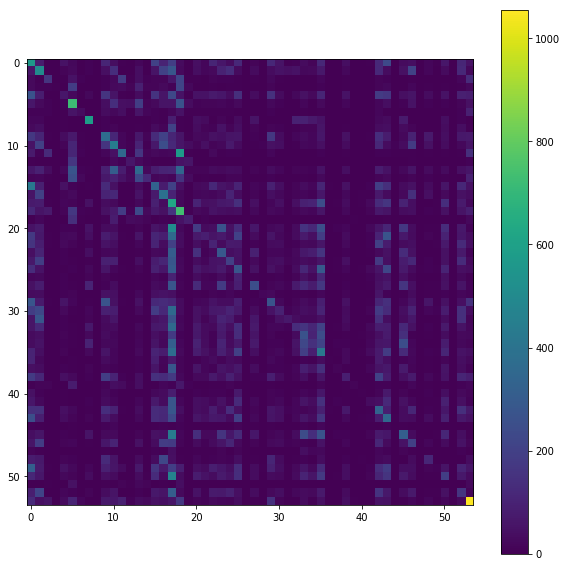

In [58]:
# confusion looks perhaps actually, that I had forgotten to also balancing out the test data.
# i'm seeing there appears to be a super high number disproportionately in the last class, 54
plt.figure(figsize=(10,10))
plt.imshow(confusion)
plt.colorbar()
plt.grid(False)
plt.show()

In [62]:
confusion[:,:].sum(axis=1)

array([2926, 2712, 1147,  882, 2853, 2171,  610, 1455,  871, 2769, 2652,
       1897,  488, 2809, 1429, 2908, 2053, 2944, 2904,  571, 2944, 2879,
       1967, 2067, 2377, 2618,  898, 2325,  690, 2621, 2970, 2006, 2540,
       1915, 2329, 2905,  901, 1502, 2557,  533,  710, 1614, 2819, 2698,
        213, 2823, 1895,  307, 1262, 2773, 2695,  219, 2131, 2673])

#### some  thoughts here
- can also balance that test set indeed because at least yes the random "accuracy" is interesting to look at , but it disproporrtionately favors the more common classes.
- And I think I feel better about an acc on a more balanced out test set as opposed to a weighted acc. 
- Although a weighted acc might be quicker to implement, 

In [63]:
from sklearn.metrics import balanced_accuracy_score

In [64]:
balanced_accuracy_score(actuals, predictions)

0.10198056214190813

In [65]:
accuracy_score(actuals, predictions)

0.11619414381515171

In [66]:
bundle_loc = f'{workdir}/bundle_with_metrics.joblib'
print('Saving to ', bundle_loc)


joblib.dump({
    
    'notebook': '2020-07-03-aws.ipynb',
    'xgb_model': xgb_model,
    'train': 'artifacts/2020-07-03T171842Z/train.libsvm?format=libsvm',
    'walltime': '4min 18s',
    'primary_dataset': '2013-07 - Citi Bike trip data.csv',
    'input_params': params,
    'num_round': num_round,
    'proc_bundle': 'artifacts/2020-07-03T171842Z/proc_bundle.joblib',
    'validation_metrics': {
        'accuracy': accuracy_score(actuals, predictions),
        'balanced_accuracy': balanced_accuracy_score(actuals, predictions),
        'confusion': confusion,
        'logloss': logloss,
        'test': 'artifacts/2020-07-03T171842Z/test.libsvm?format=libsvm'
    }


}, bundle_loc)
fu.log(workdir, f'wrote bundle {bundle_loc}')

Saving to  /home/ec2-user/SageMaker/learn-citibike/artifacts/2020-07-03T171842Z/bundle_with_metrics.joblib
